In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
with open('DataSplit.pickle', 'rb') as handle:
    DataSplit = pickle.load(handle)

In [3]:
# Hyperparameters
train_batch_size = 10
val_batch_size = 10
learning_rate = 0.0001
num_epochs = 200

In [4]:
class Senz3DDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        self.GT_labels = {'1': 5, '2': 2, '3': 3, '4': 5, '5': 0, '6': 2, 
                          '7': 1, '8': 4, '9': 3, '10': 1, '11': 1}
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = cv2.imread("..\\." + self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4)).astype(np.uint8)
        
        label = torch.tensor(self.GT_labels[(self.labels[idx])])
        
        return {'img': img, 'label': label}

In [5]:
# Make Datasets
TrainDataset = Senz3DDataset(list(DataSplit['train'].keys()), list(DataSplit['train'].values()))
ValDataset = Senz3DDataset(list(DataSplit['val'].keys()), list(DataSplit['val'].values()))
TestDataset = Senz3DDataset(list(DataSplit['test'].keys()), list(DataSplit['test'].values()))

In [6]:
#  Make DataLoaders
TrainDataLoader = DataLoader(TrainDataset, batch_size=train_batch_size, shuffle=True)
ValDataLoader = DataLoader(ValDataset, batch_size=val_batch_size, shuffle=True)
TestDataLoader = DataLoader(TestDataset, batch_size=1, shuffle=False)

In [7]:
import torchvision.models as models
model_name = 'resnext50'
model = models.resnext50_32x4d(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Linear(64,6),
    nn.Softmax(dim=1),    
    )

for i, param in enumerate(model.parameters()):
    if i < 159:
      print(f'Layer{i} frozen:', type(param), param.size())
      param.requires_grad = False
    else: 
      print(f'Layer{i} not frozen', type(param), param.size())
      param.requires_grad = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_metric = nn.CrossEntropyLoss()

Layer0 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 7, 7])
Layer1 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer2 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer3 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([128, 64, 1, 1])
Layer4 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([128])
Layer5 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([128])
Layer6 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([128, 4, 3, 3])
Layer7 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([128])
Layer8 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([128])
Layer9 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256, 128, 1, 1])
Layer10 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256])
Layer11 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256])
Layer12 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256, 64, 1, 1])
Layer13 frozen:

In [8]:
# Initialize
epoch_train_loss = []
epoch_train_accuracy = []

epoch_val_loss = []
epoch_val_accuracy = []

epoch_test_loss = []
epoch_test_accuracy = []

best_val_accuracy = 0

for epic in range(num_epochs):
    
    # Put model in training mode
    model.train()
    
    train_correct = 0
    train_total = 0
    train_loss = 0
    
    for i, sample in tqdm.tqdm(enumerate(TrainDataLoader)):
        
        # move inputs to device
        if torch.cuda.is_available():
            x = sample['img'].permute(0, 3, 1, 2).float().to(device)
            y = sample['label'].to(device)
        
        # Loop over model, calculate loss
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_metric(output, y)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy/loss
        _, y_hat = torch.max(output, dim=1)
        
        train_correct += torch.sum(y_hat == y)
        train_total += x.shape[0]
        train_loss += loss.item() * x.shape[0]
        
    # Append to epoch loss/accuracy
    epoch_train_loss.append(train_loss / train_total)
    epoch_train_accuracy.append(train_correct.float() / train_total)
    
    print(f'Epoch: {epic}, Train Loss: {epoch_train_loss[-1]}, Train Acc: {epoch_train_accuracy[-1]}')
    
    # Put model in validation mode
    model.eval()
    
    val_total = 0
    val_correct = 0
    val_loss = 0
    
    with torch.no_grad():
        for i, sample in enumerate(ValDataLoader):
            
            # move inputs to device
            if torch.cuda.is_available():
                x = sample['img'].permute(0, 3, 1, 2).float().to(device)
                y = sample['label'].to(device)

            output = model.forward(x)
            loss = loss_metric(output, y)
            
            # Calculate accuracy/loss
            _, y_hat = torch.max(output, dim=1)
            batch_correct = torch.sum(y_hat == y)
            val_correct += torch.sum(y_hat == y)
            val_total += x.shape[0]
            val_loss += loss.item() * x.shape[0]
            
    # Append to epoch loss/accuracy
    epoch_val_loss.append(val_loss / val_total)
    val_accuracy = val_correct.float() / val_total
    epoch_val_accuracy.append(val_accuracy)
    
    if val_accuracy > best_val_accuracy:
        print("Saved new best model.")
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), f'saved_models/{model_name}.pth')
    
    print(f'Epoch: {epic}, Val Loss: {epoch_val_loss[-1]}, Val Acc: {epoch_val_accuracy[-1]}')
    
    

97it [00:18,  5.19it/s]


Epoch: 0, Train Loss: 1.725117396219002, Train Acc: 0.2949117422103882
Saved new best model.
Epoch: 0, Val Loss: 1.6636451800092518, Val Acc: 0.3741007149219513

0it [00:00, ?it/s]

97it [00:18,  5.23it/s]


Epoch: 1, Train Loss: 1.6286986595868818, Train Acc: 0.4112149775028229


0it [00:00, ?it/s]

Epoch: 1, Val Loss: 1.6215890079951114, Val Acc: 0.3741007149219513


97it [00:18,  5.14it/s]


Epoch: 2, Train Loss: 1.5765173914276551, Train Acc: 0.47352027893066406
Saved new best model.


1it [00:00,  5.52it/s]

Epoch: 2, Val Loss: 1.5202750739433784, Val Acc: 0.5539568662643433


97it [00:18,  5.38it/s]


Epoch: 3, Train Loss: 1.524805685441442, Train Acc: 0.5358255505561829
Saved new best model.
Epoch: 3, Val Loss: 1.4683474225106, Val Acc: 0.5755395889282227

1it [00:00,  5.58it/s]

97it [00:17,  5.42it/s]


Epoch: 4, Train Loss: 1.4822104941523582, Train Acc: 0.5711318850517273
Saved new best model.
Epoch: 4, Val Loss: 1.441218035684215, Val Acc: 0.6187050342559814

1it [00:00,  5.55it/s]

97it [00:18,  5.37it/s]


Epoch: 5, Train Loss: 1.4635540952563657, Train Acc: 0.5867082476615906
Saved new best model.
Epoch: 5, Val Loss: 1.3999048625822548, Val Acc: 0.6834532618522644

0it [00:00, ?it/s]

97it [00:17,  5.43it/s]


Epoch: 6, Train Loss: 1.4121260163940001, Train Acc: 0.653167188167572


0it [00:00, ?it/s]

Epoch: 6, Val Loss: 1.4033883372656732, Val Acc: 0.6474820375442505


97it [00:17,  5.54it/s]


Epoch: 7, Train Loss: 1.3956764161524866, Train Acc: 0.6583593487739563


0it [00:00, ?it/s]

Epoch: 7, Val Loss: 1.3776769929652593, Val Acc: 0.6762589812278748


97it [00:17,  5.53it/s]


Epoch: 8, Train Loss: 1.4019690971136836, Train Acc: 0.6407061815261841


1it [00:00,  5.64it/s]

Epoch: 8, Val Loss: 1.3617026548591449, Val Acc: 0.6690647602081299


97it [00:17,  5.59it/s]


Epoch: 9, Train Loss: 1.384594886102409, Train Acc: 0.6645898818969727


0it [00:00, ?it/s]

Saved new best model.
Epoch: 9, Val Loss: 1.3273632251959053, Val Acc: 0.7338129878044128


97it [00:17,  5.56it/s]


Epoch: 10, Train Loss: 1.3683361351056758, Train Acc: 0.681204617023468


1it [00:00,  5.64it/s]

Epoch: 10, Val Loss: 1.323602666957773, Val Acc: 0.7338129878044128


97it [00:17,  5.47it/s]


Epoch: 11, Train Loss: 1.3340515197870764, Train Acc: 0.7165109515190125


0it [00:00, ?it/s]

Epoch: 11, Val Loss: 1.3292061707956329, Val Acc: 0.7266187071800232


97it [00:17,  5.46it/s]


Epoch: 12, Train Loss: 1.3423884084539126, Train Acc: 0.701973021030426


1it [00:00,  5.55it/s]

Epoch: 12, Val Loss: 1.3194228213468044, Val Acc: 0.7338129878044128


97it [00:17,  5.58it/s]


Epoch: 13, Train Loss: 1.33036701169217, Train Acc: 0.7185877561569214


0it [00:00, ?it/s]

Epoch: 13, Val Loss: 1.3146488486434058, Val Acc: 0.7338129878044128


97it [00:17,  5.60it/s]


Epoch: 14, Train Loss: 1.3333470529237392, Train Acc: 0.7082035541534424


0it [00:00, ?it/s]

Epoch: 14, Val Loss: 1.330231052508457, Val Acc: 0.7122302055358887


97it [00:17,  5.65it/s]


Epoch: 15, Train Loss: 1.3377726415978786, Train Acc: 0.7133956551551819


1it [00:00,  5.55it/s]

Epoch: 15, Val Loss: 1.3149877855246015, Val Acc: 0.7338129878044128


97it [00:17,  5.65it/s]


Epoch: 16, Train Loss: 1.3169057932474408, Train Acc: 0.7310488224029541


0it [00:00, ?it/s]

Saved new best model.
Epoch: 16, Val Loss: 1.3065896883285304, Val Acc: 0.7410072088241577


97it [00:17,  5.62it/s]


Epoch: 17, Train Loss: 1.327645402459712, Train Acc: 0.7154725193977356


1it [00:00,  5.64it/s]

Epoch: 17, Val Loss: 1.323012004653327, Val Acc: 0.7122302055358887


97it [00:17,  5.53it/s]


Epoch: 18, Train Loss: 1.3165870028492819, Train Acc: 0.7268951535224915


0it [00:00, ?it/s]

Saved new best model.
Epoch: 18, Val Loss: 1.277930968099361, Val Acc: 0.7697842121124268


97it [00:17,  5.66it/s]


Epoch: 19, Train Loss: 1.3245423909659697, Train Acc: 0.7175493836402893


0it [00:00, ?it/s]

Epoch: 19, Val Loss: 1.3108425071771197, Val Acc: 0.7338129878044128


97it [00:17,  5.68it/s]


Epoch: 20, Train Loss: 1.3156654105627152, Train Acc: 0.7279335856437683


0it [00:00, ?it/s]

Saved new best model.
Epoch: 20, Val Loss: 1.280078128087435, Val Acc: 0.7769784331321716


97it [00:17,  5.61it/s]


Epoch: 21, Train Loss: 1.308025143970953, Train Acc: 0.7372793555259705


1it [00:00,  5.61it/s]

Epoch: 21, Val Loss: 1.3076498191133679, Val Acc: 0.7338129878044128


97it [00:17,  5.66it/s]


Epoch: 22, Train Loss: 1.3211661575986837, Train Acc: 0.7227414846420288


1it [00:00,  5.64it/s]

Epoch: 22, Val Loss: 1.3596860787851348, Val Acc: 0.6906474828720093


97it [00:17,  5.65it/s]


Epoch: 23, Train Loss: 1.2992578075187105, Train Acc: 0.7466251850128174


0it [00:00, ?it/s]

Epoch: 23, Val Loss: 1.307395399903222, Val Acc: 0.7338129878044128


97it [00:17,  5.58it/s]


Epoch: 24, Train Loss: 1.3104140257166925, Train Acc: 0.7372793555259705


0it [00:00, ?it/s]

Epoch: 24, Val Loss: 1.3038025862879032, Val Acc: 0.7338129878044128


97it [00:17,  5.63it/s]


Epoch: 25, Train Loss: 1.3102768944307528, Train Acc: 0.7372793555259705


1it [00:00,  5.58it/s]

Epoch: 25, Val Loss: 1.29546424896597, Val Acc: 0.7482014298439026


97it [00:17,  5.64it/s]


Epoch: 26, Train Loss: 1.2945801991416164, Train Acc: 0.7528557181358337


1it [00:00,  5.61it/s]

Epoch: 26, Val Loss: 1.2980138440783933, Val Acc: 0.7410072088241577


97it [00:17,  5.65it/s]


Epoch: 27, Train Loss: 1.290881018896093, Train Acc: 0.7538940906524658


0it [00:00, ?it/s]

Epoch: 27, Val Loss: 1.2769983929695843, Val Acc: 0.7697842121124268


97it [00:17,  5.64it/s]


Epoch: 28, Train Loss: 1.3007162356302375, Train Acc: 0.7476635575294495


0it [00:00, ?it/s]

Epoch: 28, Val Loss: 1.2759749872221364, Val Acc: 0.7697842121124268


97it [00:17,  5.62it/s]


Epoch: 29, Train Loss: 1.2848259879049855, Train Acc: 0.7590862512588501


1it [00:00,  5.64it/s]

Epoch: 29, Val Loss: 1.2932342565316948, Val Acc: 0.7482014298439026


97it [00:17,  5.65it/s]


Epoch: 30, Train Loss: 1.3001861390295057, Train Acc: 0.7435098886489868


0it [00:00, ?it/s]

Epoch: 30, Val Loss: 1.302623877422415, Val Acc: 0.7410072088241577


97it [00:17,  5.53it/s]


Epoch: 31, Train Loss: 1.2733454175703498, Train Acc: 0.771547257900238


1it [00:00,  5.71it/s]

Epoch: 31, Val Loss: 1.2771954545014197, Val Acc: 0.7697842121124268


97it [00:17,  5.65it/s]


Epoch: 32, Train Loss: 1.3010981570646893, Train Acc: 0.74247145652771


1it [00:00,  5.64it/s]

Epoch: 32, Val Loss: 1.315836555666203, Val Acc: 0.7266187071800232


97it [00:17,  5.65it/s]


Epoch: 33, Train Loss: 1.2895723504564596, Train Acc: 0.7518172860145569


0it [00:00, ?it/s]

Epoch: 33, Val Loss: 1.2793429258058397, Val Acc: 0.7625899314880371


97it [00:17,  5.68it/s]


Epoch: 34, Train Loss: 1.2940622556989438, Train Acc: 0.7518172860145569


1it [00:00,  5.61it/s]

Epoch: 34, Val Loss: 1.2839044572638094, Val Acc: 0.7625899314880371


97it [00:17,  5.67it/s]


Epoch: 35, Train Loss: 1.297002559510347, Train Acc: 0.7435098886489868


1it [00:00,  5.68it/s]

Epoch: 35, Val Loss: 1.2703214540756007, Val Acc: 0.7697842121124268


97it [00:17,  5.67it/s]


Epoch: 36, Train Loss: 1.2719700168102577, Train Acc: 0.770508885383606
Saved new best model.
Epoch: 36, Val Loss: 1.2760766736037439, Val Acc: 0.7913669347763062

1it [00:00,  5.78it/s]

97it [00:17,  5.50it/s]


Epoch: 37, Train Loss: 1.2662054931634683, Train Acc: 0.7746625542640686


0it [00:00, ?it/s]

Epoch: 37, Val Loss: 1.2725789727066918, Val Acc: 0.7697842121124268


97it [00:17,  5.65it/s]


Epoch: 38, Train Loss: 1.244044918261337, Train Acc: 0.8026999235153198


1it [00:00,  5.64it/s]

Epoch: 38, Val Loss: 1.2698459565210685, Val Acc: 0.7769784331321716


97it [00:17,  5.66it/s]


Epoch: 39, Train Loss: 1.2661780611624476, Train Acc: 0.7798546552658081


1it [00:00,  5.61it/s]

Epoch: 39, Val Loss: 1.289539110746315, Val Acc: 0.7338129878044128


97it [00:17,  5.67it/s]


Epoch: 40, Train Loss: 1.273954467238667, Train Acc: 0.7725856900215149


0it [00:00, ?it/s]

Epoch: 40, Val Loss: 1.2653238301654515, Val Acc: 0.7841726541519165


97it [00:17,  5.66it/s]


Epoch: 41, Train Loss: 1.2530930729298577, Train Acc: 0.7933541536331177


1it [00:00,  5.52it/s]

Epoch: 41, Val Loss: 1.2788267530125679, Val Acc: 0.7625899314880371


97it [00:17,  5.66it/s]


Epoch: 42, Train Loss: 1.2353671826306163, Train Acc: 0.8141225576400757


0it [00:00, ?it/s]

Saved new best model.
Epoch: 42, Val Loss: 1.2541906687853148, Val Acc: 0.8057554364204407


97it [00:17,  5.58it/s]


Epoch: 43, Train Loss: 1.232079082931685, Train Acc: 0.8161994218826294
Saved new best model.
Epoch: 43, Val Loss: 1.221185613879197, Val Acc: 0.8129496574401855

1it [00:00,  5.71it/s]

97it [00:17,  5.56it/s]


Epoch: 44, Train Loss: 1.233851881661024, Train Acc: 0.8089304566383362


0it [00:00, ?it/s]

Epoch: 44, Val Loss: 1.253806293439522, Val Acc: 0.7913669347763062


97it [00:17,  5.65it/s]


Epoch: 45, Train Loss: 1.2321468371344753, Train Acc: 0.8151609897613525
Saved new best model.
Epoch: 45, Val Loss: 1.2336307506767108, Val Acc: 0.8273381590843201

1it [00:00,  5.84it/s]

97it [00:17,  5.60it/s]


Epoch: 46, Train Loss: 1.2186898699925819, Train Acc: 0.8276220560073853


1it [00:00,  5.68it/s]

Epoch: 46, Val Loss: 1.256192153306316, Val Acc: 0.798561155796051


97it [00:17,  5.71it/s]


Epoch: 47, Train Loss: 1.2119765713702604, Train Acc: 0.8369678258895874


1it [00:00,  5.68it/s]

Epoch: 47, Val Loss: 1.2451161309111891, Val Acc: 0.798561155796051


97it [00:16,  5.72it/s]


Epoch: 48, Train Loss: 1.2137088031659864, Train Acc: 0.8359293937683105


1it [00:00,  5.68it/s]

Epoch: 48, Val Loss: 1.2318565313764613, Val Acc: 0.8201438784599304


97it [00:16,  5.74it/s]


Epoch: 49, Train Loss: 1.1958331092495784, Train Acc: 0.8515057563781738


1it [00:00,  5.68it/s]

Epoch: 49, Val Loss: 1.208448765089186, Val Acc: 0.8273381590843201


97it [00:17,  5.61it/s]


Epoch: 50, Train Loss: 1.203191775646784, Train Acc: 0.8421599268913269
Saved new best model.
Epoch: 50, Val Loss: 1.1996453588815044, Val Acc: 0.8489208817481995

1it [00:00,  5.81it/s]

97it [00:17,  5.68it/s]


Epoch: 51, Train Loss: 1.1891200016344572, Train Acc: 0.860851526260376


1it [00:00,  5.71it/s]

Epoch: 51, Val Loss: 1.2077766613994572, Val Acc: 0.8489208817481995


97it [00:17,  5.70it/s]


Epoch: 52, Train Loss: 1.1922409786984929, Train Acc: 0.8618899583816528


1it [00:00,  5.81it/s]

Epoch: 52, Val Loss: 1.2091541393197698, Val Acc: 0.8417266607284546


97it [00:17,  5.70it/s]


Epoch: 53, Train Loss: 1.1757228903062371, Train Acc: 0.869158923625946


1it [00:00,  5.68it/s]

Epoch: 53, Val Loss: 1.2040913585278628, Val Acc: 0.8417266607284546


97it [00:17,  5.69it/s]


Epoch: 54, Train Loss: 1.1873892827940136, Train Acc: 0.8598130941390991


0it [00:00, ?it/s]

Epoch: 54, Val Loss: 1.2051209811684038, Val Acc: 0.8417266607284546


97it [00:17,  5.69it/s]


Epoch: 55, Train Loss: 1.1823250852517497, Train Acc: 0.8598130941390991


1it [00:00,  5.52it/s]

Epoch: 55, Val Loss: 1.1918115247067789, Val Acc: 0.8417266607284546


97it [00:17,  5.63it/s]


Epoch: 56, Train Loss: 1.1717874644825144, Train Acc: 0.8805815577507019


0it [00:00, ?it/s]

Epoch: 56, Val Loss: 1.2410041205316997, Val Acc: 0.8129496574401855


97it [00:17,  5.66it/s]


Epoch: 57, Train Loss: 1.175236823031464, Train Acc: 0.8764278888702393
Saved new best model.
Epoch: 57, Val Loss: 1.1745432272231837, Val Acc: 0.863309383392334

1it [00:00,  5.84it/s]

97it [00:17,  5.66it/s]


Epoch: 58, Train Loss: 1.1571921815753354, Train Acc: 0.8951194286346436
Saved new best model.
Epoch: 58, Val Loss: 1.1720289832396473, Val Acc: 0.8776978850364685


97it [00:17,  5.68it/s]


Epoch: 59, Train Loss: 1.153659347556957, Train Acc: 0.9003115892410278


1it [00:00,  5.64it/s]

Epoch: 59, Val Loss: 1.186354900435578, Val Acc: 0.863309383392334


97it [00:16,  5.73it/s]


Epoch: 60, Train Loss: 1.1403834136475655, Train Acc: 0.9106957912445068


1it [00:00,  5.68it/s]

Epoch: 60, Val Loss: 1.178345277155046, Val Acc: 0.8705036044120789


97it [00:16,  5.74it/s]


Epoch: 61, Train Loss: 1.145924057915946, Train Acc: 0.9127725958824158
Saved new best model.
Epoch: 61, Val Loss: 1.1448723703837222, Val Acc: 0.8992806077003479

1it [00:00,  5.81it/s]

97it [00:17,  5.70it/s]


Epoch: 62, Train Loss: 1.1178011639219703, Train Acc: 0.9345794916152954
Saved new best model.
Epoch: 62, Val Loss: 1.1416745408833455, Val Acc: 0.9208633303642273

1it [00:00,  5.84it/s]

97it [00:17,  5.56it/s]


Epoch: 63, Train Loss: 1.1213593253960614, Train Acc: 0.9293873906135559


1it [00:00,  5.68it/s]

Epoch: 63, Val Loss: 1.1503688783096753, Val Acc: 0.8848921060562134


97it [00:17,  5.68it/s]


Epoch: 64, Train Loss: 1.099998742249153, Train Acc: 0.9532710909843445
Saved new best model.
Epoch: 64, Val Loss: 1.1098981915618018, Val Acc: 0.9424460530281067

1it [00:00,  5.84it/s]

97it [00:17,  5.69it/s]


Epoch: 65, Train Loss: 1.112555561902491, Train Acc: 0.9439252614974976


1it [00:00,  5.68it/s]

Epoch: 65, Val Loss: 1.1128801956451198, Val Acc: 0.9424460530281067


97it [00:17,  5.68it/s]


Epoch: 66, Train Loss: 1.1062847474901352, Train Acc: 0.9449636936187744


1it [00:00,  5.74it/s]

Epoch: 66, Val Loss: 1.1367026610340145, Val Acc: 0.9064748287200928


97it [00:17,  5.70it/s]


Epoch: 67, Train Loss: 1.0928329531401242, Train Acc: 0.9615784287452698


1it [00:00,  5.64it/s]

Epoch: 67, Val Loss: 1.1175601370900654, Val Acc: 0.9280575513839722


97it [00:16,  5.71it/s]


Epoch: 68, Train Loss: 1.0964494417513395, Train Acc: 0.9543094635009766
Saved new best model.
Epoch: 68, Val Loss: 1.1143130621464132, Val Acc: 0.9496403336524963

1it [00:00,  5.84it/s]

97it [00:17,  5.59it/s]


Epoch: 69, Train Loss: 1.0866631804225602, Train Acc: 0.9605399966239929


1it [00:00,  5.58it/s]

Epoch: 69, Val Loss: 1.121367048016555, Val Acc: 0.9280575513839722


97it [00:16,  5.71it/s]


Epoch: 70, Train Loss: 1.089802607197628, Train Acc: 0.958463191986084
Saved new best model.
Epoch: 70, Val Loss: 1.0942740852026631, Val Acc: 0.9568345546722412

1it [00:00,  5.84it/s]

97it [00:17,  5.68it/s]


Epoch: 71, Train Loss: 1.0736076706790232, Train Acc: 0.9771547913551331


0it [00:00, ?it/s]

Epoch: 71, Val Loss: 1.1067450749788352, Val Acc: 0.9280575513839722


97it [00:16,  5.71it/s]


Epoch: 72, Train Loss: 1.0828436900274527, Train Acc: 0.9709242582321167


0it [00:00, ?it/s]

Epoch: 72, Val Loss: 1.1014264393195832, Val Acc: 0.9424460530281067


97it [00:16,  5.74it/s]


Epoch: 73, Train Loss: 1.0805513815468841, Train Acc: 0.9678089618682861


1it [00:00,  5.78it/s]

Epoch: 73, Val Loss: 1.1366244897567968, Val Acc: 0.9064748287200928


97it [00:16,  5.74it/s]


Epoch: 74, Train Loss: 1.089245702990119, Train Acc: 0.9595016241073608


1it [00:00,  5.71it/s]

Epoch: 74, Val Loss: 1.110010400092859, Val Acc: 0.9424460530281067


97it [00:16,  5.73it/s]


Epoch: 75, Train Loss: 1.06940702399237, Train Acc: 0.9813084602355957


1it [00:00,  5.49it/s]

Epoch: 75, Val Loss: 1.0893104333671735, Val Acc: 0.9568345546722412


97it [00:17,  5.64it/s]


Epoch: 76, Train Loss: 1.0740584182095552, Train Acc: 0.9761163592338562


0it [00:00, ?it/s]

Epoch: 76, Val Loss: 1.1055152296162338, Val Acc: 0.9424460530281067


97it [00:16,  5.73it/s]


Epoch: 77, Train Loss: 1.0903713694490254, Train Acc: 0.9553478956222534


1it [00:00,  5.74it/s]

Epoch: 77, Val Loss: 1.1266060715956654, Val Acc: 0.9280575513839722


97it [00:17,  5.69it/s]


Epoch: 78, Train Loss: 1.0745933980585258, Train Acc: 0.979231595993042
Saved new best model.
Epoch: 78, Val Loss: 1.0798642944088943, Val Acc: 0.9640287756919861

1it [00:00,  5.81it/s]

97it [00:17,  5.68it/s]


Epoch: 79, Train Loss: 1.0817184111534746, Train Acc: 0.9657321572303772


1it [00:00,  5.71it/s]

Epoch: 79, Val Loss: 1.1186269290155644, Val Acc: 0.9352518320083618


97it [00:16,  5.74it/s]


Epoch: 80, Train Loss: 1.070683409863172, Train Acc: 0.9761163592338562


1it [00:00,  5.74it/s]

Epoch: 80, Val Loss: 1.0943180245461224, Val Acc: 0.9568345546722412


97it [00:16,  5.74it/s]


Epoch: 81, Train Loss: 1.0788445381113054, Train Acc: 0.9667705297470093


1it [00:00,  5.71it/s]

Epoch: 81, Val Loss: 1.092606775194621, Val Acc: 0.9640287756919861


97it [00:17,  5.62it/s]


Epoch: 82, Train Loss: 1.0919353151123348, Train Acc: 0.9574247598648071


1it [00:00,  5.64it/s]

Epoch: 82, Val Loss: 1.1113204835987778, Val Acc: 0.9352518320083618


97it [00:17,  5.70it/s]


Epoch: 83, Train Loss: 1.074081018087401, Train Acc: 0.9740394949913025


1it [00:00,  5.68it/s]

Epoch: 83, Val Loss: 1.1287962721406126, Val Acc: 0.9136691093444824


97it [00:17,  5.69it/s]


Epoch: 84, Train Loss: 1.0722830754821793, Train Acc: 0.9740394949913025


1it [00:00,  5.64it/s]

Epoch: 84, Val Loss: 1.0912258504963608, Val Acc: 0.9640287756919861


97it [00:17,  5.69it/s]


Epoch: 85, Train Loss: 1.0607070081082954, Train Acc: 0.9865005612373352


1it [00:00,  5.68it/s]

Epoch: 85, Val Loss: 1.129012521222341, Val Acc: 0.9064748287200928


97it [00:16,  5.74it/s]


Epoch: 86, Train Loss: 1.0756670682229728, Train Acc: 0.9719626307487488


0it [00:00, ?it/s]

Epoch: 86, Val Loss: 1.1002077910539916, Val Acc: 0.9496403336524963


97it [00:16,  5.76it/s]


Epoch: 87, Train Loss: 1.0719368808118477, Train Acc: 0.979231595993042


0it [00:00, ?it/s]

Epoch: 87, Val Loss: 1.090773275430254, Val Acc: 0.9568345546722412


97it [00:17,  5.70it/s]


Epoch: 88, Train Loss: 1.072096984458242, Train Acc: 0.9771547913551331


1it [00:00,  5.61it/s]

Epoch: 88, Val Loss: 1.1126104001518633, Val Acc: 0.9280575513839722


97it [00:17,  5.66it/s]


Epoch: 89, Train Loss: 1.082640621025862, Train Acc: 0.9626168608665466


1it [00:00,  5.71it/s]

Epoch: 89, Val Loss: 1.1065070955015772, Val Acc: 0.9496403336524963


97it [00:16,  5.74it/s]


Epoch: 90, Train Loss: 1.0747153476762623, Train Acc: 0.9719626307487488


0it [00:00, ?it/s]

Saved new best model.
Epoch: 90, Val Loss: 1.074927628469124, Val Acc: 0.9784172773361206


97it [00:17,  5.69it/s]


Epoch: 91, Train Loss: 1.0787840955353971, Train Acc: 0.9698858261108398


0it [00:00, ?it/s]

Epoch: 91, Val Loss: 1.0765675357777438, Val Acc: 0.9712230563163757


97it [00:16,  5.74it/s]


Epoch: 92, Train Loss: 1.0646721812918674, Train Acc: 0.9802700281143188


1it [00:00,  5.78it/s]

Epoch: 92, Val Loss: 1.1235313364070096, Val Acc: 0.9136691093444824


97it [00:16,  5.74it/s]


Epoch: 93, Train Loss: 1.0747904515093114, Train Acc: 0.9709242582321167


1it [00:00,  5.74it/s]

Epoch: 93, Val Loss: 1.0881884321034383, Val Acc: 0.9568345546722412


97it [00:16,  5.73it/s]


Epoch: 94, Train Loss: 1.0548893438568987, Train Acc: 0.9916926622390747


1it [00:00,  5.74it/s]

Epoch: 94, Val Loss: 1.082978865225538, Val Acc: 0.9712230563163757


97it [00:17,  5.61it/s]


Epoch: 95, Train Loss: 1.0634997232680752, Train Acc: 0.9833853244781494


0it [00:00, ?it/s]

Epoch: 95, Val Loss: 1.097447108021743, Val Acc: 0.9496403336524963


97it [00:16,  5.73it/s]


Epoch: 96, Train Loss: 1.0607128201491611, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 96, Val Loss: 1.0809883633963495, Val Acc: 0.9640287756919861


97it [00:16,  5.74it/s]


Epoch: 97, Train Loss: 1.0642837783629278, Train Acc: 0.9833853244781494


1it [00:00,  5.71it/s]

Epoch: 97, Val Loss: 1.0873945291093785, Val Acc: 0.9640287756919861


97it [00:16,  5.73it/s]


Epoch: 98, Train Loss: 1.066401137246026, Train Acc: 0.979231595993042


1it [00:00,  5.68it/s]

Epoch: 98, Val Loss: 1.0879498737321482, Val Acc: 0.9712230563163757


97it [00:16,  5.73it/s]


Epoch: 99, Train Loss: 1.071159612847761, Train Acc: 0.9730010628700256


1it [00:00,  5.64it/s]

Epoch: 99, Val Loss: 1.0827948875564466, Val Acc: 0.9640287756919861


97it [00:16,  5.71it/s]


Epoch: 100, Train Loss: 1.0621589840634467, Train Acc: 0.9844236969947815


1it [00:00,  5.68it/s]

Epoch: 100, Val Loss: 1.0951035914661216, Val Acc: 0.9496403336524963


97it [00:17,  5.68it/s]


Epoch: 101, Train Loss: 1.0703043147906088, Train Acc: 0.9750779271125793


0it [00:00, ?it/s]

Epoch: 101, Val Loss: 1.0816018752914538, Val Acc: 0.9712230563163757


97it [00:17,  5.63it/s]


Epoch: 102, Train Loss: 1.063647705817891, Train Acc: 0.9833853244781494


1it [00:00,  5.68it/s]

Epoch: 102, Val Loss: 1.1053301507620503, Val Acc: 0.9280575513839722


97it [00:16,  5.71it/s]


Epoch: 103, Train Loss: 1.0718792129776065, Train Acc: 0.9730010628700256


1it [00:00,  5.64it/s]

Epoch: 103, Val Loss: 1.0949465928317832, Val Acc: 0.9352518320083618


97it [00:17,  5.70it/s]


Epoch: 104, Train Loss: 1.0751538223442878, Train Acc: 0.968847393989563


1it [00:00,  5.68it/s]

Epoch: 104, Val Loss: 1.0955763652170305, Val Acc: 0.9496403336524963


97it [00:17,  5.70it/s]


Epoch: 105, Train Loss: 1.0569811972749814, Train Acc: 0.9916926622390747


1it [00:00,  5.61it/s]

Epoch: 105, Val Loss: 1.1007683723092936, Val Acc: 0.9496403336524963


97it [00:17,  5.70it/s]


Epoch: 106, Train Loss: 1.0548679210934189, Train Acc: 0.989615797996521


1it [00:00,  5.58it/s]

Epoch: 106, Val Loss: 1.072183199923673, Val Acc: 0.9784172773361206


97it [00:16,  5.71it/s]


Epoch: 107, Train Loss: 1.0648951034060643, Train Acc: 0.9823468923568726


0it [00:00, ?it/s]

Epoch: 107, Val Loss: 1.0813103905684656, Val Acc: 0.9640287756919861


97it [00:17,  5.60it/s]


Epoch: 108, Train Loss: 1.0720709624196387, Train Acc: 0.9750779271125793


1it [00:00,  5.58it/s]

Epoch: 108, Val Loss: 1.0677032436398293, Val Acc: 0.9784172773361206


97it [00:17,  5.68it/s]


Epoch: 109, Train Loss: 1.0565821337179975, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 109, Val Loss: 1.0899899571919613, Val Acc: 0.9640287756919861


97it [00:17,  5.69it/s]


Epoch: 110, Train Loss: 1.0680159507387028, Train Acc: 0.9781931638717651


0it [00:00, ?it/s]

Epoch: 110, Val Loss: 1.0966815202356242, Val Acc: 0.9496403336524963


97it [00:17,  5.68it/s]


Epoch: 111, Train Loss: 1.0630663427855986, Train Acc: 0.9854621291160583


1it [00:00,  5.71it/s]

Epoch: 111, Val Loss: 1.0836186237472425, Val Acc: 0.9640287756919861


97it [00:16,  5.75it/s]


Epoch: 112, Train Loss: 1.0612339708540175, Train Acc: 0.9844236969947815


0it [00:00, ?it/s]

Epoch: 112, Val Loss: 1.075068384623356, Val Acc: 0.9712230563163757


97it [00:16,  5.74it/s]


Epoch: 113, Train Loss: 1.0579789223329301, Train Acc: 0.9865005612373352


1it [00:00,  5.81it/s]

Epoch: 113, Val Loss: 1.071664073484407, Val Acc: 0.9784172773361206


97it [00:17,  5.69it/s]


Epoch: 114, Train Loss: 1.069914486425564, Train Acc: 0.9730010628700256


0it [00:00, ?it/s]

Epoch: 114, Val Loss: 1.0797382481664204, Val Acc: 0.9640287756919861


97it [00:17,  5.69it/s]


Epoch: 115, Train Loss: 1.0654439845684285, Train Acc: 0.9854621291160583


0it [00:00, ?it/s]

Epoch: 115, Val Loss: 1.0883733428639473, Val Acc: 0.9568345546722412


97it [00:16,  5.76it/s]


Epoch: 116, Train Loss: 1.0568683432146273, Train Acc: 0.9906542301177979


1it [00:00,  5.74it/s]

Epoch: 116, Val Loss: 1.0975933855386089, Val Acc: 0.9496403336524963


97it [00:16,  5.75it/s]


Epoch: 117, Train Loss: 1.05787018353075, Train Acc: 0.9885774254798889


1it [00:00,  5.64it/s]

Epoch: 117, Val Loss: 1.072533806450933, Val Acc: 0.9712230563163757


97it [00:17,  5.70it/s]


Epoch: 118, Train Loss: 1.068879250920574, Train Acc: 0.9750779271125793


0it [00:00, ?it/s]

Epoch: 118, Val Loss: 1.1023665649427785, Val Acc: 0.9424460530281067


97it [00:17,  5.70it/s]


Epoch: 119, Train Loss: 1.0615089429873172, Train Acc: 0.9833853244781494


1it [00:00,  5.68it/s]

Epoch: 119, Val Loss: 1.0983894591708836, Val Acc: 0.9424460530281067


97it [00:17,  5.71it/s]


Epoch: 120, Train Loss: 1.0622381905281408, Train Acc: 0.9823468923568726


1it [00:00,  5.78it/s]

Epoch: 120, Val Loss: 1.0834402008879958, Val Acc: 0.9712230563163757


97it [00:17,  5.59it/s]


Epoch: 121, Train Loss: 1.064382558794903, Train Acc: 0.979231595993042


1it [00:00,  5.61it/s]

Epoch: 121, Val Loss: 1.0762507023571206, Val Acc: 0.9712230563163757


97it [00:16,  5.71it/s]


Epoch: 122, Train Loss: 1.058127806317893, Train Acc: 0.989615797996521


1it [00:00,  5.78it/s]

Epoch: 122, Val Loss: 1.0829510740238986, Val Acc: 0.9568345546722412


97it [00:17,  5.70it/s]


Epoch: 123, Train Loss: 1.0602122703692871, Train Acc: 0.9844236969947815


0it [00:00, ?it/s]

Epoch: 123, Val Loss: 1.0846131396808212, Val Acc: 0.9640287756919861


97it [00:17,  5.70it/s]


Epoch: 124, Train Loss: 1.0644254296987103, Train Acc: 0.9813084602355957


0it [00:00, ?it/s]

Epoch: 124, Val Loss: 1.0921791062938224, Val Acc: 0.9496403336524963


97it [00:16,  5.73it/s]


Epoch: 125, Train Loss: 1.058795633717118, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 125, Val Loss: 1.0986065555819504, Val Acc: 0.9496403336524963


97it [00:16,  5.74it/s]


Epoch: 126, Train Loss: 1.05297505682255, Train Acc: 0.9906542301177979


1it [00:00,  5.68it/s]

Epoch: 126, Val Loss: 1.0804790378474503, Val Acc: 0.9568345546722412


97it [00:17,  5.67it/s]


Epoch: 127, Train Loss: 1.0657819211173527, Train Acc: 0.9802700281143188


0it [00:00, ?it/s]

Epoch: 127, Val Loss: 1.1050627197293068, Val Acc: 0.9352518320083618


97it [00:17,  5.69it/s]


Epoch: 128, Train Loss: 1.0622977543223808, Train Acc: 0.9823468923568726


1it [00:00,  5.64it/s]

Epoch: 128, Val Loss: 1.0956791948071487, Val Acc: 0.9496403336524963


97it [00:16,  5.73it/s]


Epoch: 129, Train Loss: 1.0625120549929847, Train Acc: 0.9813084602355957


1it [00:00,  5.74it/s]

Epoch: 129, Val Loss: 1.1094525863798401, Val Acc: 0.9280575513839722


97it [00:16,  5.73it/s]


Epoch: 130, Train Loss: 1.05521911549791, Train Acc: 0.9916926622390747


0it [00:00, ?it/s]

Epoch: 130, Val Loss: 1.088027280011623, Val Acc: 0.9568345546722412


97it [00:16,  5.73it/s]


Epoch: 131, Train Loss: 1.0617443048322683, Train Acc: 0.9833853244781494


1it [00:00,  5.61it/s]

Epoch: 131, Val Loss: 1.10025434099513, Val Acc: 0.9496403336524963


97it [00:16,  5.73it/s]


Epoch: 132, Train Loss: 1.0594115697953808, Train Acc: 0.9875389933586121


0it [00:00, ?it/s]

Epoch: 132, Val Loss: 1.0754617564112163, Val Acc: 0.9712230563163757


97it [00:16,  5.74it/s]


Epoch: 133, Train Loss: 1.0574583840147358, Train Acc: 0.9875389933586121


0it [00:00, ?it/s]

Epoch: 133, Val Loss: 1.0969605926129458, Val Acc: 0.9496403336524963


97it [00:17,  5.60it/s]


Epoch: 134, Train Loss: 1.0606840314152084, Train Acc: 0.9844236969947815


1it [00:00,  5.74it/s]

Epoch: 134, Val Loss: 1.113644938674762, Val Acc: 0.9424460530281067


97it [00:16,  5.72it/s]


Epoch: 135, Train Loss: 1.06534063209502, Train Acc: 0.979231595993042


1it [00:00,  5.78it/s]

Epoch: 135, Val Loss: 1.0935700094099525, Val Acc: 0.9568345546722412


97it [00:16,  5.72it/s]


Epoch: 136, Train Loss: 1.0541621574112683, Train Acc: 0.9916926622390747


1it [00:00,  5.64it/s]

Epoch: 136, Val Loss: 1.1046423534695193, Val Acc: 0.9424460530281067


97it [00:16,  5.72it/s]


Epoch: 137, Train Loss: 1.0588508396257617, Train Acc: 0.9865005612373352


1it [00:00,  5.78it/s]

Epoch: 137, Val Loss: 1.092573869142601, Val Acc: 0.9496403336524963


97it [00:16,  5.72it/s]


Epoch: 138, Train Loss: 1.0576375729074607, Train Acc: 0.9875389933586121


0it [00:00, ?it/s]

Epoch: 138, Val Loss: 1.1056372887796635, Val Acc: 0.9352518320083618


97it [00:16,  5.72it/s]


Epoch: 139, Train Loss: 1.0586313177615807, Train Acc: 0.9854621291160583


1it [00:00,  5.68it/s]

Epoch: 139, Val Loss: 1.0794905201136638, Val Acc: 0.9496403336524963


97it [00:17,  5.65it/s]


Epoch: 140, Train Loss: 1.063271055959343, Train Acc: 0.9813084602355957


1it [00:00,  5.40it/s]

Epoch: 140, Val Loss: 1.0878544008131508, Val Acc: 0.9568345546722412


97it [00:17,  5.62it/s]


Epoch: 141, Train Loss: 1.0485849244324712, Train Acc: 0.9968847632408142


1it [00:00,  5.64it/s]

Epoch: 141, Val Loss: 1.0912403237047812, Val Acc: 0.9568345546722412


97it [00:17,  5.70it/s]


Epoch: 142, Train Loss: 1.059553296642759, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 142, Val Loss: 1.0853850404135614, Val Acc: 0.9568345546722412


97it [00:17,  5.62it/s]


Epoch: 143, Train Loss: 1.0496616634624398, Train Acc: 0.9948079586029053


1it [00:00,  5.74it/s]

Epoch: 143, Val Loss: 1.078266946531886, Val Acc: 0.9712230563163757


97it [00:17,  5.70it/s]


Epoch: 144, Train Loss: 1.0551249072311575, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 144, Val Loss: 1.088206568210245, Val Acc: 0.9568345546722412


97it [00:17,  5.69it/s]


Epoch: 145, Train Loss: 1.0531147750614835, Train Acc: 0.9927310943603516


1it [00:00,  5.74it/s]

Epoch: 145, Val Loss: 1.086547997358034, Val Acc: 0.9568345546722412


97it [00:16,  5.71it/s]


Epoch: 146, Train Loss: 1.071727067634448, Train Acc: 0.9719626307487488


1it [00:00,  5.61it/s]

Epoch: 146, Val Loss: 1.1142068475270444, Val Acc: 0.9280575513839722


97it [00:17,  5.59it/s]


Epoch: 147, Train Loss: 1.052494828079596, Train Acc: 0.9937695264816284


1it [00:00,  5.71it/s]

Epoch: 147, Val Loss: 1.1036866543104322, Val Acc: 0.9352518320083618


97it [00:17,  5.68it/s]


Epoch: 148, Train Loss: 1.0666243758899772, Train Acc: 0.979231595993042


1it [00:00,  5.61it/s]

Epoch: 148, Val Loss: 1.0933522732137777, Val Acc: 0.9496403336524963


97it [00:17,  5.69it/s]


Epoch: 149, Train Loss: 1.0575439374147297, Train Acc: 0.9885774254798889


0it [00:00, ?it/s]

Epoch: 149, Val Loss: 1.0904281756860748, Val Acc: 0.9568345546722412


97it [00:17,  5.68it/s]


Epoch: 150, Train Loss: 1.0587130668626272, Train Acc: 0.9854621291160583


1it [00:00,  5.74it/s]

Epoch: 150, Val Loss: 1.0850821313240546, Val Acc: 0.9568345546722412


97it [00:16,  5.71it/s]


Epoch: 151, Train Loss: 1.0523423254799373, Train Acc: 0.9937695264816284
Saved new best model.
Epoch: 151, Val Loss: 1.0579718325635512, Val Acc: 0.9928057789802551

1it [00:00,  5.81it/s]

97it [00:17,  5.67it/s]


Epoch: 152, Train Loss: 1.0518711503297244, Train Acc: 0.9916926622390747


1it [00:00,  5.64it/s]

Epoch: 152, Val Loss: 1.0656196479317095, Val Acc: 0.9784172773361206


97it [00:17,  5.61it/s]


Epoch: 153, Train Loss: 1.057797061938982, Train Acc: 0.9865005612373352


1it [00:00,  5.58it/s]

Epoch: 153, Val Loss: 1.0762159112546084, Val Acc: 0.9712230563163757


97it [00:17,  5.70it/s]


Epoch: 154, Train Loss: 1.0698756942620282, Train Acc: 0.9709242582321167


1it [00:00,  5.71it/s]

Epoch: 154, Val Loss: 1.0842471225656194, Val Acc: 0.9568345546722412


97it [00:16,  5.71it/s]


Epoch: 155, Train Loss: 1.0504481794925742, Train Acc: 0.9937695264816284


1it [00:00,  5.84it/s]

Epoch: 155, Val Loss: 1.1164804851408485, Val Acc: 0.9136691093444824


97it [00:16,  5.71it/s]


Epoch: 156, Train Loss: 1.0514418154119332, Train Acc: 0.9948079586029053


1it [00:00,  5.64it/s]

Epoch: 156, Val Loss: 1.0882834487681767, Val Acc: 0.9640287756919861


97it [00:17,  5.69it/s]


Epoch: 157, Train Loss: 1.0557711454938135, Train Acc: 0.9885774254798889


1it [00:00,  5.64it/s]

Epoch: 157, Val Loss: 1.0785406982298378, Val Acc: 0.9640287756919861


97it [00:17,  5.70it/s]


Epoch: 158, Train Loss: 1.0557501092011559, Train Acc: 0.989615797996521


1it [00:00,  5.58it/s]

Epoch: 158, Val Loss: 1.0877965800196148, Val Acc: 0.9568345546722412


97it [00:17,  5.69it/s]


Epoch: 159, Train Loss: 1.0483266672241354, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 159, Val Loss: 1.083509128728359, Val Acc: 0.9640287756919861


97it [00:17,  5.64it/s]


Epoch: 160, Train Loss: 1.0548354733893928, Train Acc: 0.9906542301177979


1it [00:00,  5.68it/s]

Epoch: 160, Val Loss: 1.0913470134460668, Val Acc: 0.9496403336524963


97it [00:16,  5.74it/s]


Epoch: 161, Train Loss: 1.060077933012387, Train Acc: 0.9833853244781494


1it [00:00,  5.71it/s]

Epoch: 161, Val Loss: 1.1148380735795276, Val Acc: 0.9280575513839722


97it [00:16,  5.74it/s]


Epoch: 162, Train Loss: 1.0543994444305405, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 162, Val Loss: 1.0705312696292246, Val Acc: 0.9784172773361206


97it [00:16,  5.72it/s]


Epoch: 163, Train Loss: 1.0479305862513906, Train Acc: 0.9968847632408142


1it [00:00,  5.78it/s]

Epoch: 163, Val Loss: 1.0788575333657024, Val Acc: 0.9640287756919861


97it [00:16,  5.72it/s]


Epoch: 164, Train Loss: 1.0536495902704177, Train Acc: 0.989615797996521


1it [00:00,  5.68it/s]

Epoch: 164, Val Loss: 1.0733256219959946, Val Acc: 0.9712230563163757


97it [00:16,  5.73it/s]


Epoch: 165, Train Loss: 1.0528660532346272, Train Acc: 0.9927310943603516


1it [00:00,  5.78it/s]

Epoch: 165, Val Loss: 1.1030119957683755, Val Acc: 0.9424460530281067


97it [00:17,  5.59it/s]


Epoch: 166, Train Loss: 1.0504398969846351, Train Acc: 0.9937695264816284


1it [00:00,  5.71it/s]

Epoch: 166, Val Loss: 1.1137364142232662, Val Acc: 0.9280575513839722


97it [00:16,  5.73it/s]


Epoch: 167, Train Loss: 1.0522180803096925, Train Acc: 0.9916926622390747


1it [00:00,  5.74it/s]

Epoch: 167, Val Loss: 1.0822920010244246, Val Acc: 0.9640287756919861


97it [00:16,  5.74it/s]


Epoch: 168, Train Loss: 1.048709967054682, Train Acc: 0.9958463311195374


1it [00:00,  5.64it/s]

Epoch: 168, Val Loss: 1.0933385667183417, Val Acc: 0.9496403336524963


97it [00:16,  5.72it/s]


Epoch: 169, Train Loss: 1.051654532567239, Train Acc: 0.9937695264816284


1it [00:00,  5.71it/s]

Epoch: 169, Val Loss: 1.1108675800639092, Val Acc: 0.9352518320083618


97it [00:16,  5.73it/s]


Epoch: 170, Train Loss: 1.0566897901047798, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 170, Val Loss: 1.1098147896553974, Val Acc: 0.9280575513839722


97it [00:16,  5.74it/s]


Epoch: 171, Train Loss: 1.0573682936057371, Train Acc: 0.9875389933586121


0it [00:00, ?it/s]

Epoch: 171, Val Loss: 1.0710367521793722, Val Acc: 0.9784172773361206


97it [00:16,  5.71it/s]


Epoch: 172, Train Loss: 1.0498935167415615, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 172, Val Loss: 1.1360940650212679, Val Acc: 0.9064748287200928


97it [00:17,  5.64it/s]


Epoch: 173, Train Loss: 1.0730800669512646, Train Acc: 0.9709242582321167


0it [00:00, ?it/s]

Epoch: 173, Val Loss: 1.0757569957980149, Val Acc: 0.9784172773361206


97it [00:17,  5.70it/s]


Epoch: 174, Train Loss: 1.0641295039641399, Train Acc: 0.9802700281143188


1it [00:00,  5.61it/s]

Epoch: 174, Val Loss: 1.0740093515931273, Val Acc: 0.9712230563163757


97it [00:17,  5.65it/s]


Epoch: 175, Train Loss: 1.05031765175757, Train Acc: 0.9948079586029053


1it [00:00,  5.78it/s]

Epoch: 175, Val Loss: 1.0922843518017007, Val Acc: 0.9496403336524963


97it [00:17,  5.70it/s]


Epoch: 176, Train Loss: 1.0500055217297277, Train Acc: 0.9937695264816284


1it [00:00,  5.61it/s]

Epoch: 176, Val Loss: 1.0828794403899489, Val Acc: 0.9640287756919861


97it [00:16,  5.71it/s]


Epoch: 177, Train Loss: 1.0554934133497973, Train Acc: 0.989615797996521


1it [00:00,  5.71it/s]

Epoch: 177, Val Loss: 1.085027024042692, Val Acc: 0.9568345546722412


97it [00:16,  5.74it/s]


Epoch: 178, Train Loss: 1.0508448776797714, Train Acc: 0.9948079586029053


1it [00:00,  5.71it/s]

Epoch: 178, Val Loss: 1.0901815179440615, Val Acc: 0.9496403336524963


97it [00:17,  5.60it/s]


Epoch: 179, Train Loss: 1.053064121635532, Train Acc: 0.9916926622390747


1it [00:00,  5.74it/s]

Epoch: 179, Val Loss: 1.0945311330205245, Val Acc: 0.9568345546722412


97it [00:16,  5.72it/s]


Epoch: 180, Train Loss: 1.0711032112563263, Train Acc: 0.9719626307487488


1it [00:00,  5.71it/s]

Epoch: 180, Val Loss: 1.0738708672763633, Val Acc: 0.9712230563163757


97it [00:16,  5.74it/s]


Epoch: 181, Train Loss: 1.061796330836208, Train Acc: 0.9823468923568726


0it [00:00, ?it/s]

Epoch: 181, Val Loss: 1.1217362297524651, Val Acc: 0.9136691093444824


97it [00:16,  5.74it/s]


Epoch: 182, Train Loss: 1.0546354268322604, Train Acc: 0.9885774254798889


1it [00:00,  5.74it/s]

Epoch: 182, Val Loss: 1.0785400464380388, Val Acc: 0.9640287756919861


97it [00:16,  5.74it/s]


Epoch: 183, Train Loss: 1.0514248631824956, Train Acc: 0.9916926622390747


0it [00:00, ?it/s]

Epoch: 183, Val Loss: 1.0836284023394687, Val Acc: 0.9640287756919861


97it [00:16,  5.73it/s]


Epoch: 184, Train Loss: 1.0746096755113927, Train Acc: 0.9678089618682861


0it [00:00, ?it/s]

Epoch: 184, Val Loss: 1.098150700116329, Val Acc: 0.9424460530281067


97it [00:17,  5.69it/s]


Epoch: 185, Train Loss: 1.0501279853214727, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 185, Val Loss: 1.0945991946638918, Val Acc: 0.9496403336524963


97it [00:17,  5.64it/s]


Epoch: 186, Train Loss: 1.064809810830549, Train Acc: 0.979231595993042


1it [00:00,  5.71it/s]

Epoch: 186, Val Loss: 1.1059868575857699, Val Acc: 0.9352518320083618


97it [00:17,  5.70it/s]


Epoch: 187, Train Loss: 1.0573226973522738, Train Acc: 0.9885774254798889


0it [00:00, ?it/s]

Epoch: 187, Val Loss: 1.0865102851991173, Val Acc: 0.9568345546722412


97it [00:17,  5.70it/s]


Epoch: 188, Train Loss: 1.0571793718872784, Train Acc: 0.9875389933586121


1it [00:00,  5.74it/s]

Epoch: 188, Val Loss: 1.088649678573334, Val Acc: 0.9568345546722412


97it [00:17,  5.69it/s]


Epoch: 189, Train Loss: 1.0533652716584172, Train Acc: 0.9927310943603516


1it [00:00,  5.71it/s]

Epoch: 189, Val Loss: 1.0844078887280801, Val Acc: 0.9568345546722412


97it [00:16,  5.73it/s]


Epoch: 190, Train Loss: 1.055515447757202, Train Acc: 0.9885774254798889


1it [00:00,  5.74it/s]

Epoch: 190, Val Loss: 1.095916886123822, Val Acc: 0.9424460530281067


97it [00:16,  5.73it/s]


Epoch: 191, Train Loss: 1.048725508826544, Train Acc: 0.9968847632408142


1it [00:00,  5.64it/s]

Epoch: 191, Val Loss: 1.0698727489375381, Val Acc: 0.9712230563163757


97it [00:17,  5.61it/s]


Epoch: 192, Train Loss: 1.053779631884051, Train Acc: 0.989615797996521


0it [00:00, ?it/s]

Epoch: 192, Val Loss: 1.1003069851895888, Val Acc: 0.9424460530281067


97it [00:16,  5.73it/s]


Epoch: 193, Train Loss: 1.0554028281541628, Train Acc: 0.989615797996521


1it [00:00,  5.74it/s]

Epoch: 193, Val Loss: 1.0860087631417692, Val Acc: 0.9568345546722412


97it [00:16,  5.74it/s]


Epoch: 194, Train Loss: 1.0529543801383932, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 194, Val Loss: 1.0649946988057748, Val Acc: 0.9928057789802551


97it [00:16,  5.74it/s]


Epoch: 195, Train Loss: 1.0608852881385036, Train Acc: 0.9813084602355957


0it [00:00, ?it/s]

Epoch: 195, Val Loss: 1.0915141397242925, Val Acc: 0.9568345546722412


97it [00:16,  5.75it/s]


Epoch: 196, Train Loss: 1.0535092044347047, Train Acc: 0.9906542301177979


1it [00:00,  5.71it/s]

Epoch: 196, Val Loss: 1.0739807079164245, Val Acc: 0.9712230563163757


97it [00:16,  5.74it/s]


Epoch: 197, Train Loss: 1.0482655577941846, Train Acc: 0.9958463311195374


1it [00:00,  5.74it/s]

Epoch: 197, Val Loss: 1.0839168811015945, Val Acc: 0.9568345546722412


97it [00:17,  5.68it/s]


Epoch: 198, Train Loss: 1.0492192014107946, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 198, Val Loss: 1.0925235413818908, Val Acc: 0.9496403336524963


97it [00:17,  5.67it/s]


Epoch: 199, Train Loss: 1.0563556616922776, Train Acc: 0.9865005612373352
Epoch: 199, Val Loss: 1.073475277681145, Val Acc: 0.9712230563163757


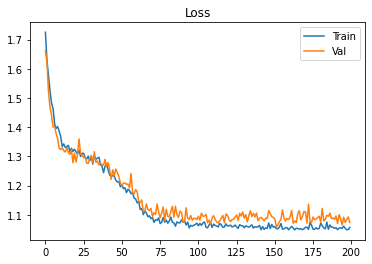

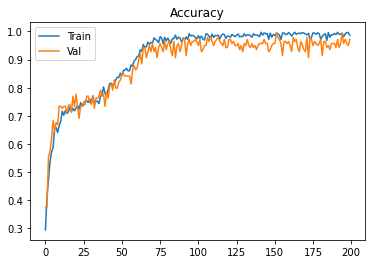

In [9]:
plt.figure(1)
plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)
plt.title("Loss")
plt.legend(("Train", "Val"))

plt.figure(2)
plt.plot(epoch_train_accuracy)
plt.plot(epoch_val_accuracy)
plt.title("Accuracy")
plt.legend(("Train", "Val"))

In [10]:
max(epoch_val_accuracy)

tensor(0.9928, device='cuda:0')